In [1]:
%reload_ext autoreload
%autoreload 2 

In [2]:
import os
import sys

# Get the directory of the script being run
current_dir = os.path.dirname(os.path.abspath("__file__"))

# Get the parent directory of the current directory
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to sys.path to make the preprocessing module discoverable
sys.path.append(parent_dir)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import optuna

from preprocessing.text_preprocessing import preprocess_data
from utils.model_utils import save_model

/Users/rakshitgupta/Desktop/SMU/MCDA 5580 DATA AND TEXT MINING/02 ASSIGNMENTS/ClassificationAssignment/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rakshitgupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rakshitgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rakshitgupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rakshitgupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
df = pd.read_csv('../data/train.csv', encoding='ISO-8859-1')

## Text Preprocessing

In [5]:
columns_to_remove=['textID','Time of Tweet','selected_text', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']
df_processed = preprocess_data(df, text_column_name='text',columns_to_remove=columns_to_remove)

## Baseline Model

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_processed['text'], df_processed['sentiment'], test_size=0.2, random_state=1)
tfidf_vectorizer = TfidfVectorizer(lowercase=True)    
x_train_transformed = tfidf_vectorizer.fit_transform(x_train)
x_test_transformed = tfidf_vectorizer.transform(x_test)
model_mnb = MultinomialNB(alpha = 1)
model_mnb.fit(x_train_transformed, y_train)
predictions = model_mnb.predict(x_test_transformed)

In [7]:
print(classification_report(y_test, predictions,zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.43      0.54      1504
           1       0.55      0.81      0.66      2259
           2       0.76      0.59      0.66      1734

    accuracy                           0.63      5497
   macro avg       0.69      0.61      0.62      5497
weighted avg       0.67      0.63      0.63      5497



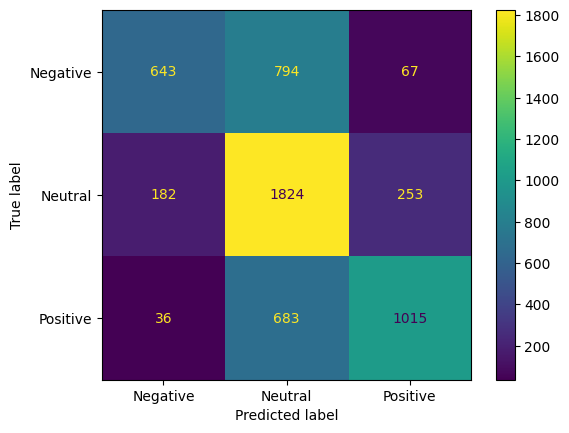

In [8]:
cm =confusion_matrix(y_test, predictions)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])
display_cm.plot()

## Hyper Parameter Tuning using Optuna


In [9]:
def objective(trial):
    # Extended hyperparameter search space
    alpha = trial.suggest_float('alpha', 1e-4, 10.0)
    lowercase = trial.suggest_categorical('lowercase', [True, False])
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (2, 2)])
    max_df = trial.suggest_float('max_df', 0.5, 1.0)
    min_df = trial.suggest_int('min_df', 1, 5)
    max_features = trial.suggest_categorical('max_features', [None, 5000, 10000, 20000])
    fit_prior = trial.suggest_categorical('fit_prior', [True, False])
    
    # Setting up the pipeline
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=lowercase, 
        ngram_range=ngram_range, 
        max_df=max_df, 
        min_df=min_df, 
        max_features=max_features
    )
    model_mnb = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    
    pipeline = make_pipeline(tfidf_vectorizer, model_mnb)
    pipeline.fit(x_train, y_train)
    predictions = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy


In [10]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  

# Retrieve the best parameters
best_params = study.best_params
best_accuracy = study.best_value


# Train the final model using the best parameters
best_pipeline = make_pipeline(
    TfidfVectorizer(lowercase=best_params['lowercase']),
    MultinomialNB(alpha=best_params['alpha'])
)

best_pipeline.fit(x_train, y_train)

[I 2024-03-30 18:37:06,700] A new study created in memory with name: no-name-b1cbd956-ac2f-4490-82c0-332e6a908cb9


/Users/rakshitgupta/Desktop/SMU/MCDA 5580 DATA AND TEXT MINING/02 ASSIGNMENTS/ClassificationAssignment/myenv/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/Users/rakshitgupta/Desktop/SMU/MCDA 5580 DATA AND TEXT MINING/02 ASSIGNMENTS/ClassificationAssignment/myenv/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/Users/rakshitgupta/Desktop/SMU/MCDA 5580 DATA AND TEXT MINING/02 ASSIGNMENTS/ClassificationAssignment/myenv/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for pe

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=9.733556488462309))])

In [11]:
print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy}")

Best parameters: {'alpha': 9.733556488462309, 'lowercase': True, 'ngram_range': (1, 2), 'max_df': 0.8690944657092534, 'min_df': 5, 'max_features': 10000, 'fit_prior': False}
Best accuracy: 0.6601782790613062


In [14]:
save_model(best_pipeline, '../models/multinomialNB_classifier.pkl')